In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision import models,datasets
import matplotlib.pyplot as plt

cat_img=Image.open('./1280px-Felis_silvestris_catus_lying_on_rice_straw.jpg')
transform_224= transforms.Compose([
    transforms.Resize(224), 
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
])


cat_img_224=transform_224(cat_img)
net = models.vgg16(pretrained=True)# 修改这里可以更换其他与训练的模型
inputs=cat_img_224[np.newaxis] #这两个方法都可以cat_img_224[None,::]
out = net(inputs)
_, preds = torch.max(out.data, 1)
preds
label=preds.numpy()[0]
label

428

In [2]:
import sys
sys.path.insert(0,'./src/')
def rgb2gray(rgb):
    return np.dot(rgb[...,:3],[0.299,0.587,0.114])
def rescale_grads(map,gradtype="all"):
    if(gradtype=="pos"):
        map=(np.maximum(0,map)/map.max())
    elif gradtype=='neg':
        map=(np.maximum(0,-map)/-map.min())
    else:
        map=map-map.min()
        map/=map.max()
    return map

In [3]:
inputs.requires_grad=True  # 必须有
from guided_backprop import GuidedBackprop # 直接引用写好的方法
GB=GuidedBackprop(net)
gp_grads=GB.generate_gradients(inputs,label)
gp_grads=np.moveaxis(gp_grads,0,-1)
# 我们分别计算三类的gp
ag=rescale_grads(gp_grads,gradtype="all")
pg=rescale_grads(gp_grads,gradtype='pos')
ng=rescale_grads(gp_grads,gradtype="neg")

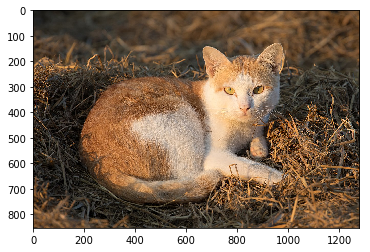

In [4]:
plt.imshow(cat_img)

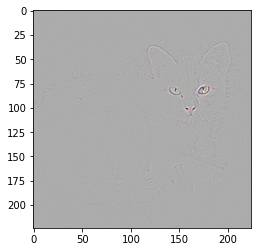

In [6]:
plt.imshow(ag)

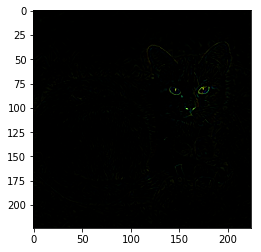

In [11]:
plt.imshow(ng)

In [5]:
# Grad-CAM
import math
from gradcam import GradCam
from guided_gradcam import guided_grad_cam
from guided_backprop import GuidedBackprop
nlayers=len(net.features._modules.items())-1
print(nlayers) # 打印一共多少层
cam_list=[] 
# 循环每一层
for layer in range(nlayers):
    print(layer)
    # GradCam
    grad_cam=GradCam(net,target_layer=layer)
    cam=grad_cam.generate_cam(inputs,label)
    # GuidedBackprop
    GBP=GuidedBackprop(net)
    guided_grads=GBP.generate_gradients(inputs,label)
    #guided Grad cam
    cam_gb=guided_grad_cam(cam,guided_grads)
    cam_list.append(rgb2gray(np.moveaxis(cam_gb,0,-1)))

30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


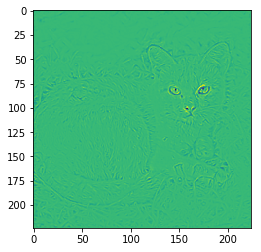

In [6]:
plt.imshow(cam_list[0])